# DoWhy 

Causal Inference has four steps - 
1. **Model** a causal inference problem using assumptions.
2. **Identify** an expression for the causal effect under these assumptions (“causal estimand”).
3. **Estimate** the expression using statistical methods such as matching or instrumental variables.
4. Finally, **verify validity** of the estimate using a variety of robustness checks.

In **DoWhy** there are four verbs to capture this workflow - 
* model
* identify
* estimate
* refute

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import dowhy
from dowhy.do_why import CausalModel
import dowhy.datasets
import numpy as np
import pandas as pd
import networkx as nx

## Step 1: Model 
* DoWhy requires graph to be specified in Graph Markup Language (GML)
* We will use `networkx` library to model our custom graph 

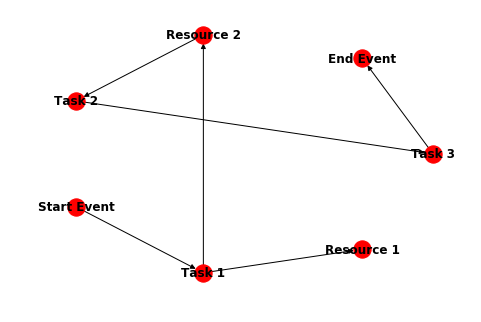

In [2]:
lucas_graph = nx.DiGraph()
lucas_graph.add_edges_from([
("Task 3",      "End Event"),
("Resource 2",  "Task 2"), 
("Start Event", "Task 1" ),   
("Task 2", "Task 3"  ),  
("Task 1", "Resource 1"),
("Task 1", "Resource 2")])

nx.draw_circular(lucas_graph, with_labels=True, font_weight='bold')

### Generate GML String
`dowhy` required the graph to be specified in GML.

In [3]:
lucas_graph_str = ''.join(list(nx.generate_gml(lucas_graph)))

In [4]:
lucas_graph_str

'graph [  directed 1  node [    id 0    label "Task 3"  ]  node [    id 1    label "End Event"  ]  node [    id 2    label "Resource 2"  ]  node [    id 3    label "Task 2"  ]  node [    id 4    label "Start Event"  ]  node [    id 5    label "Task 1"  ]  node [    id 6    label "Resource 1"  ]  edge [    source 0    target 1  ]  edge [    source 2    target 3  ]  edge [    source 3    target 0  ]  edge [    source 4    target 5  ]  edge [    source 5    target 6  ]  edge [    source 5    target 2  ]]'

### Read LUCAS data

In [5]:
df = pd.read_csv('new_aggregate.csv')
df.head()

,Resource 1,Resource 2,Start Event,Task 1,Task 2,Task 3,End Event
0,5,2,4,4,2,2,2
1,7,2,3,3,3,3,3
2,7,4,4,3,4,4,4
3,6,3,3,3,3,3,3
4,7,3,4,5,3,2,2


### Create a `dowhy` causal model

In [7]:
lucas_model = CausalModel(
                data = df,
                treatment="Task 2",
                outcome="End Event",
                graph=lucas_graph_str
                )

Model to find the causal effect of treatment Task 2 on outcome End Event


/Users/tanmayee/anaconda/envs/py36/lib/python3.6/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: Could not load "/Users/tanmayee/anaconda/envs/py36/lib/graphviz/libgvplugin_pango.6.dylib" - file not found

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


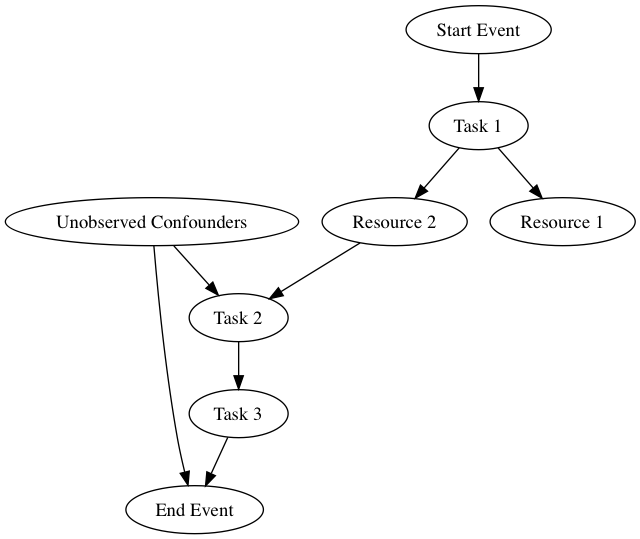

In [8]:
lucas_model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Step 2: Identify Estimand
Estimand is a mathematical expression and not a quantity.

In [9]:
# Identify causal effect and return target estimands
identified_estimand = lucas_model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U', 'Resource 2', 'Task 1', 'Start Event'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Resource 2']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                         
───────(Expectation(End Event|Resource 2,Task 1,Start Event))
dTask 2                                                      
Estimand assumption 1, Unconfoundedness: If U→Task 2 and U→End Event then P(End Event|Task 2,Resource 2,Task 1,Start Event,U) = P(End Event|Task 2,Resource 2,Task 1,Start Event)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(End Event, Resource 2)/Derivative(Task 2, Resource 2))
Estimand assumption 1, As-if-random: If U→→End Event then ¬(U →→Resource 2)
Estimand assumption 2, Exclusion: If we remove {Resource 2}→Task 2, then ¬(Resource 2→End Event)



## Step 3: Estimate Causal Effect
In this step, we use the data to estimate the causal effect using the estimand.

### Propensity Score Matching

In [11]:
# Estimate the target estimand using a statistical method.
psm_estimate = lucas_model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(psm_estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: End Event~Task 2+Resource 2+Task 1+Start Event


PropensityScoreMatchingEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                         
───────(Expectation(End Event|Resource 2,Task 1,Start Event))
dTask 2                                                      
Estimand assumption 1, Unconfoundedness: If U→Task 2 and U→End Event then P(End Event|Task 2,Resource 2,Task 1,Start Event,U) = P(End Event|Task 2,Resource 2,Task 1,Start Event)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(End Event, Resource 2)/Derivative(Task 2, Resource 2))
Estimand assumption 1, As-if-random: If U→→End Event then ¬(U →→Resource 2)
Estimand assumption 2, Exclusion: If we remove {Resource 2}→Task 2, then ¬(Resource 2→End Event)

## Realized estimand
b: End Event~Task 2+Resource 2+Task 1+Start Event
## Estimate
Value: 0.5172413793103449



### Regression

In [12]:
regression_estimate = lucas_model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(regression_estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: End Event~Task 2+Resource 2+Task 1+Start Event


LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                         
───────(Expectation(End Event|Resource 2,Task 1,Start Event))
dTask 2                                                      
Estimand assumption 1, Unconfoundedness: If U→Task 2 and U→End Event then P(End Event|Task 2,Resource 2,Task 1,Start Event,U) = P(End Event|Task 2,Resource 2,Task 1,Start Event)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(End Event, Resource 2)/Derivative(Task 2, Resource 2))
Estimand assumption 1, As-if-random: If U→→End Event then ¬(U →→Resource 2)
Estimand assumption 2, Exclusion: If we remove {Resource 2}→Task 2, then ¬(Resource 2→End Event)

## Realized estimand
b: End Event~Task 2+Resource 2+Task 1+Start Event
## Estimate
Value: 0.8024441898988764

## Statistical Significance
p-value: 0.0



## Step 4: Verify, Validate and Refute

### Propensity Score Matching

In [13]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, psm_estimate,
        method_name="random_common_cause")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: End Event~Task 2+Resource 2+Task 1+Start Event+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.5172413793103449,)
New effect:(0.5172413793103449,)



In [14]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, psm_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: End Event~placebo+Resource 2+Task 1+Start Event


Refute: Use a Placebo Treatment
Estimated effect:(0.5172413793103449,)
New effect:(0.0,)



In [15]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, psm_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: End Event~Task 2+Resource 2+Task 1+Start Event


Refute: Use a subset of data
Estimated effect:(0.5172413793103449,)
New effect:(0.5272727272727272,)



### Regression

In [16]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, regression_estimate,
        method_name="random_common_cause")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: End Event~Task 2+Resource 2+Task 1+Start Event+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.8024441898988764,)
New effect:(0.8025321474622825,)



In [17]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, regression_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: End Event~placebo+Resource 2+Task 1+Start Event


Refute: Use a Placebo Treatment
Estimated effect:(0.8024441898988764,)
New effect:(-0.004879023480803918,)



In [18]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, regression_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: End Event~Task 2+Resource 2+Task 1+Start Event


Refute: Use a subset of data
Estimated effect:(0.8024441898988764,)
New effect:(0.8020369227068489,)

